In [1]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='browser'
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [2]:
two_composite_filtered = pd.read_csv("../Curated_data/two_composite_filtered.csv", low_memory=False)


In [3]:

variable = 'Density_gcm3'
covariates = ['Sulph1_Code', 'Sulph1_Pct', 'Sulph2_Code', 'Sulph2_Pct']
hole = 'KV139'

#Select columns of interest
selected_columns = ["Name", 'X', 'Y', 'Z', variable] + covariates
two_composite_1covariates = two_composite_filtered[selected_columns]

#Drop NA's and filter for the chosen hole
two_composite_1covariates = two_composite_1covariates.dropna(subset=[variable] + covariates)
two_composite_1covariates_1hole = two_composite_1covariates.loc[two_composite_1covariates['Name'] == hole]

In [5]:
two_composite_1covariates_1hole

,Name,X,Y,Z,Density_gcm3,Sulph1_Code,Sulph1_Pct,Sulph2_Code,Sulph2_Pct
11499,KV139,3498896.02,7512447.42,216.26,2.95,PO,1.00,CP,1.0
11500,KV139,3498896.69,7512447.35,214.38,3.01,PO,1.10,CP,1.0
11501,KV139,3498897.35,7512447.27,212.49,3.21,PO,2.85,CP,1.0
11502,KV139,3498898.02,7512447.20,210.61,3.23,PO,3.60,CP,1.8
11503,KV139,3498898.69,7512447.12,208.73,3.24,PO,4.00,CP,2.0
...,...,...,...,...,...,...,...,...,...
12055,KV139,3499181.48,7512399.35,-855.57,2.94,PO,0.20,CP,0.1
12056,KV139,3499181.95,7512399.24,-857.51,2.89,PO,0.20,CP,0.1
12064,KV139,3499185.64,7512398.31,-873.05,2.72,PO,5.00,CP,0.4
12065,KV139,3499186.10,7512398.19,-875.00,2.69,PO,5.00,CP,0.4


In [6]:

encoded_data = two_composite_1covariates_1hole.copy()

threshold = 10

for column in two_composite_1covariates_1hole.columns:
    if two_composite_1covariates_1hole[column].dtype == 'object':
        unique_values = two_composite_1covariates_1hole[column].nunique()
        
        # Check if the number of unique values is within the threshold
        if unique_values <= threshold:
            # Perform one-hot encoding for columns with unique values within the threshold
            encoded_columns = pd.get_dummies(encoded_data[column], prefix=column)
            encoded_columns = encoded_columns.astype(int)  # Convert to integers (0 or 1)
            encoded_data = pd.concat([encoded_data, encoded_columns], axis=1)
            encoded_data = encoded_data.drop(columns=[column])



In [7]:
# Identify the encoded columns based on the common pattern
encoded_columns = [col for col in encoded_data.columns if '_Code_' in col]

# List to store the total columns
total_columns = []

# Iterate through the encoded columns and calculate the total for each category
for col in encoded_columns:
    # Extract the prefix and original column name
    prefix, original_column = col.split('_Code_')
    
    # Calculate the total for the category
    total_column = f"{original_column}_Total"
    total_columns.append(total_column)
    
    # Multiply the code column by the corresponding percentage column and sum them
    encoded_data[total_column] = (
        encoded_data[f"{prefix}_Code_{original_column}"] * encoded_data[f"{prefix}_Pct"]
    )

In [8]:
# List to store the total columns
total_columns = []

# Initialize a dictionary to accumulate totals for each category
category_totals = {}

# Iterate through the encoded columns and calculate the total for each category
for col in encoded_columns:
    # Extract the prefix and original column name
    prefix, original_column = col.split('_Code_')
    
    # Calculate the total for the category
    total_column = f"{original_column}_Total"
    if total_column not in total_columns:
        total_columns.append(total_column)
    
    # Multiply the code column by the corresponding percentage column
    total_values = encoded_data[f"{prefix}_Code_{original_column}"] * encoded_data[f"{prefix}_Pct"]
    
    # Accumulate the totals for each category
    if total_column in category_totals:
        category_totals[total_column] += total_values
    else:
        category_totals[total_column] = total_values

# Add accumulated totals to the DataFrame
for total_column, total_values in category_totals.items():
    encoded_data[total_column] = total_values


In [9]:
two_composite_1covariates_1hole = encoded_data[["X", "Y", "Z", "Density_gcm3"] + total_columns]
covariates = total_columns

C:\Users\flea0265\AppData\Local\Temp\ipykernel_9536\4110654578.py:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\flea0265\AppData\Local\Temp\ipykernel_9536\4110654578.py:44: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



- Iteration 0, MSE: 0.674
- Iteration 1000, MSE: 0.014
- Iteration 2000, MSE: 0.013
- Iteration 3000, MSE: 0.012


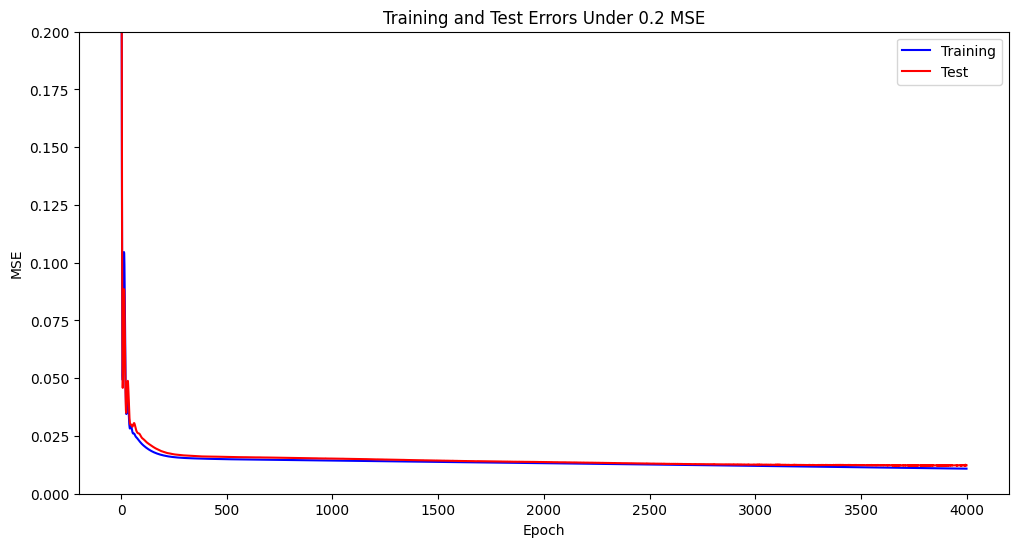

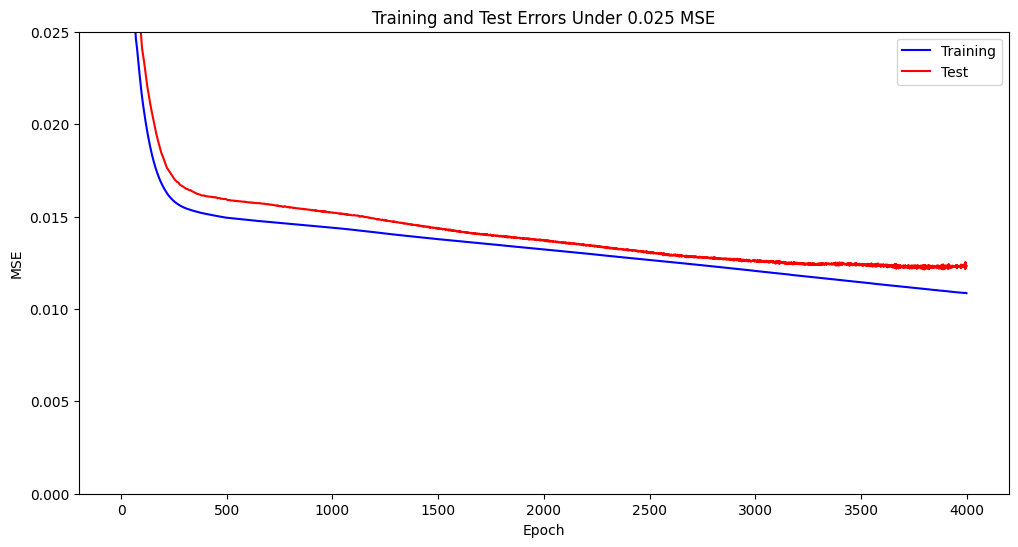

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


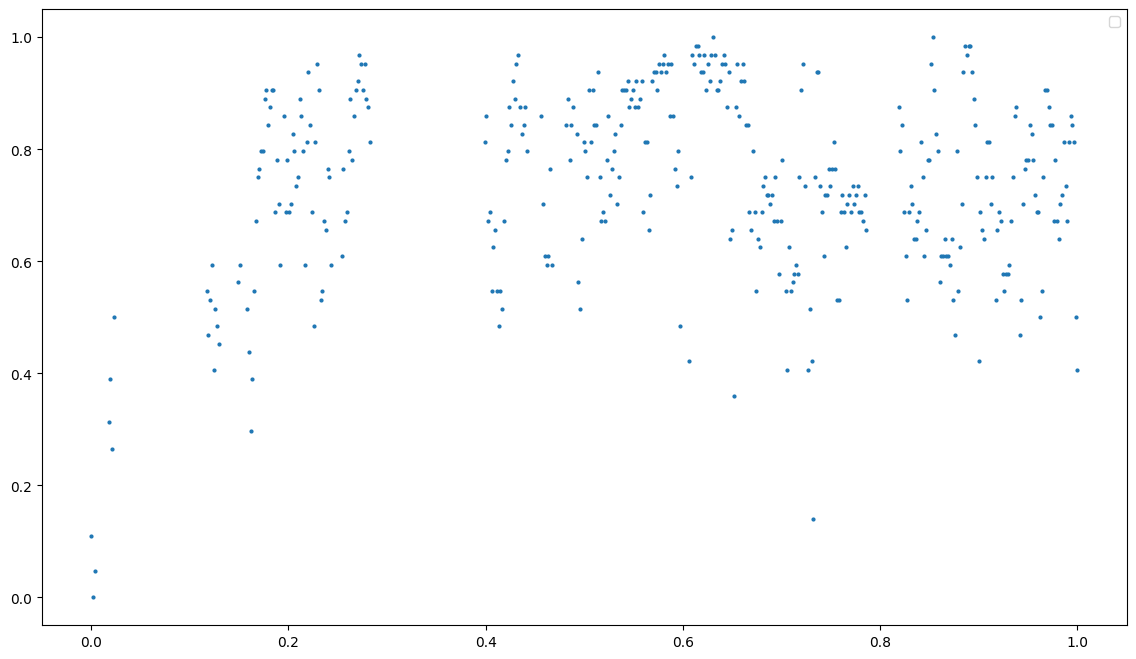

Text(0.5, 1.0, 'Density_gcm3')

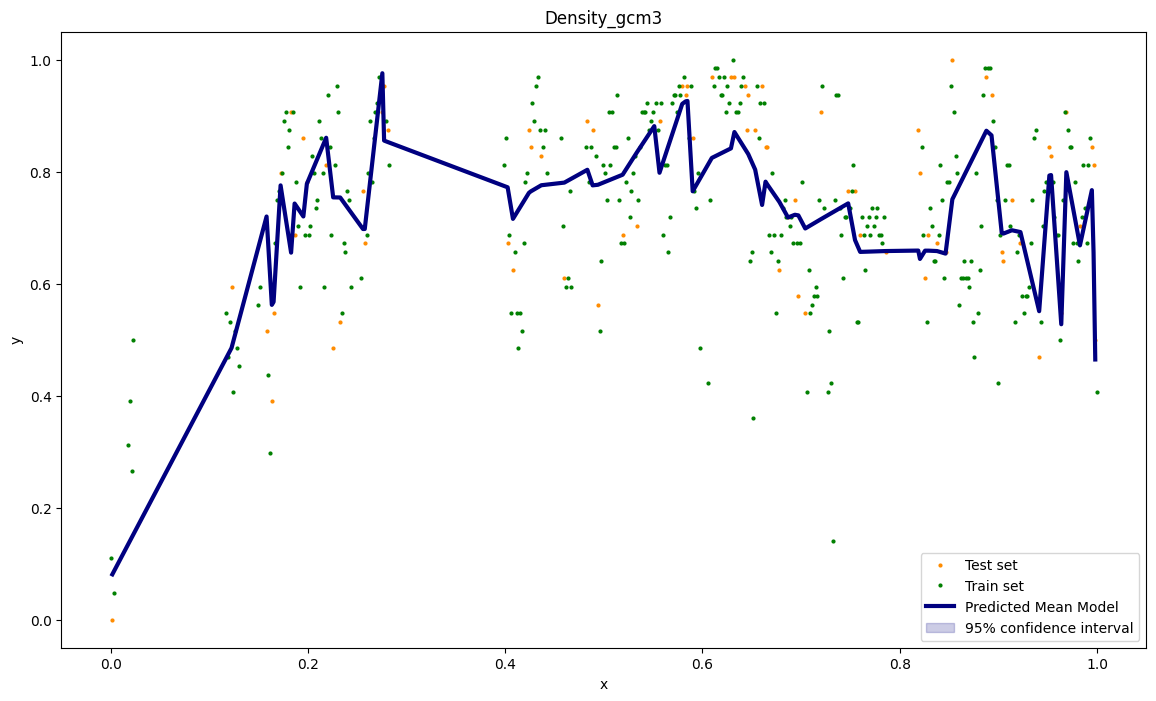

In [21]:
np.random.seed(42)
torch.manual_seed(42)

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Fit the scaler to your data and transform the specified columns
two_composite_1covariates_1hole[['Z', variable] + covariates] = scaler.fit_transform(two_composite_1covariates_1hole[['Z',variable] + covariates])



two_composite_1covariates_1hole=two_composite_1covariates_1hole.sort_values(by='Z')

x = two_composite_1covariates_1hole[['X','Y', 'Z'] + covariates].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
y = two_composite_1covariates_1hole[[variable]].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
x = x.reshape(len(two_composite_1covariates_1hole),5)

x = x[:,[2,3,4]]

x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)

# Determine the size of the test set (e.g., 20% of the data)
test_size = int(0.2 * len(x))

# Generate random indices for the test set
test_indices = np.random.choice(len(x), size=test_size, replace=False)

# Create train and test sets based on the indices
x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]

x_test = x[np.sort(test_indices)]
y_test = y[np.sort(test_indices)]



import matplotlib.pyplot as plt

# Create train and test sets
x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)

# Split the data into train and test sets
test_size = int(0.2 * len(x))
test_indices = np.random.choice(len(x), size=test_size, replace=False)
x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]
x_test = x[np.sort(test_indices)]
y_test = y[np.sort(test_indices)]

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

model = nn.Sequential(
    nn.Linear(in_features=3, out_features=500),
    nn.ReLU(),
    nn.Linear(in_features=500, out_features=1)
)

mse_loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []  # To store training losses during training
test_losses = []   # To store test losses during training

for step in range(4000):
    pre = model(x_train)
    mse = mse_loss(pre, y_train)
    cost = mse

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    pre_train = model(x_train)
    mse_train = mse_loss(pre_train, y_train)
    train_losses.append(mse_train.item())

    # Evaluate the model on the test set
    pre_test = model(x_test)
    mse_test = mse_loss(pre_test, y_test)
    test_losses.append(mse_test.item())

    if step % 1000 == 0:
        print(f'- Iteration {step}, MSE: {mse.item():.3f}')


# Create a plot showing only values under 0.2 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.2)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.2 MSE')
plt.show()



# Create a plot showing only values under 0.05 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.025)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.025 MSE')
plt.show()








models_result = np.array([model(x_test).detach().numpy() for k in range(1)])

models_result = models_result[:, :, 0]
models_result = models_result.T
mean_values = np.array([models_result[i].mean() for i in range(len(models_result))])
std_values = np.array([models_result[i].std() for i in range(len(models_result))])

plt.figure(figsize=(14,8))
plt.scatter(x.data.numpy()[:,0], y.data.numpy(), s=4)
plt.legend()
plt.show()

plt.figure(figsize=(14,8))
plt.plot(x_test.data.numpy()[:,0],y_test.data.numpy()[:,0],'.',color='darkorange',markersize=4,label='Test set')
plt.plot(x_train.data.numpy()[:,0],y_train.data.numpy()[:,0],'.',color='green',markersize=4,label='Train set')



plt.plot(x_test.data.numpy()[:, 0],mean_values,color='navy',lw=3,label='Predicted Mean Model')
plt.fill_between(x_test.data.numpy()[:, 0],mean_values-2.0*std_values,mean_values+2.0*std_values,alpha=0.2,color='navy',label='95% confidence interval')



#for x_val in x_test.data.numpy()[:, 0]:
#    plt.vlines(x_val, ymin=y_test.data.numpy()[:,0].min(), ymax=y_test.data.numpy()[:,0].max(), linestyle='--', color='black', alpha=0.1)

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title(variable)

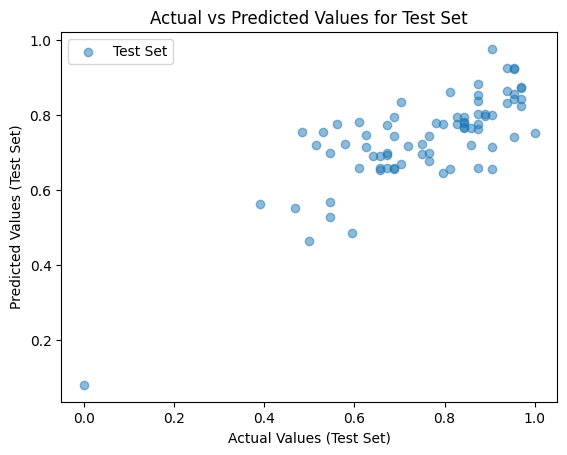

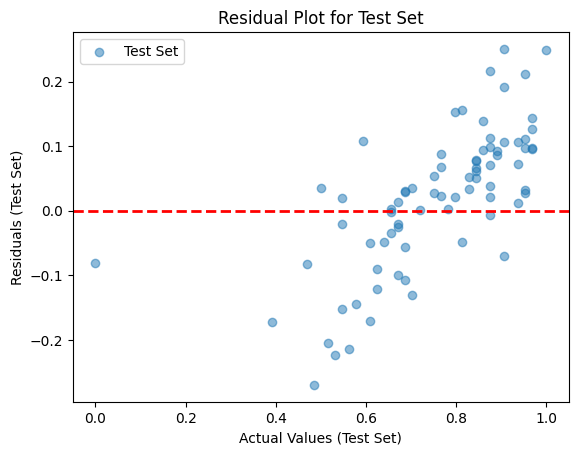

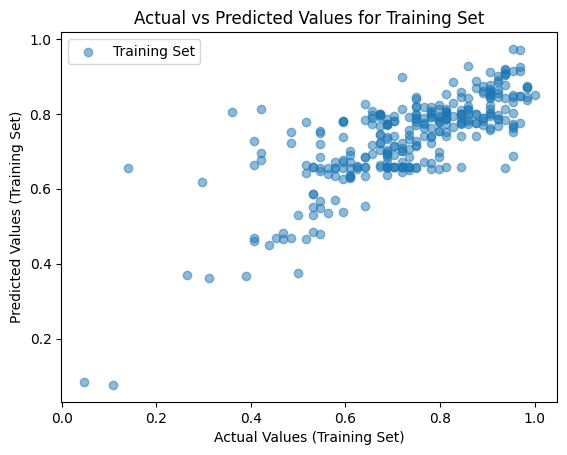

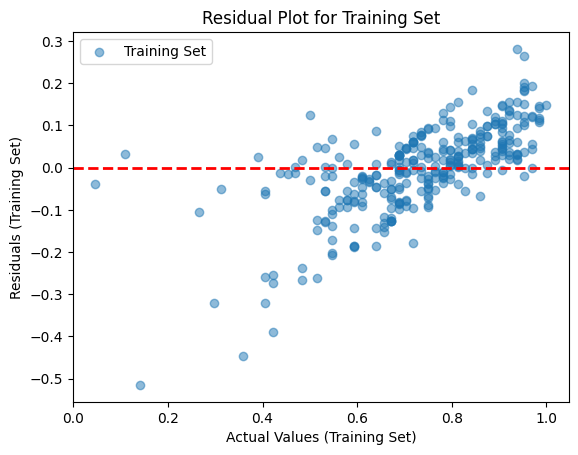

In [11]:
import matplotlib.pyplot as plt

# Generate predictions for the test set
test_predictions = model(x_test)

# Convert torch tensors to NumPy arrays
y_test_np = y_test.numpy()
test_predictions_np = test_predictions.detach().numpy()

# Plot actual vs predicted values for the test set
plt.scatter(y_test_np, test_predictions_np, alpha=0.5, label='Test Set')
plt.xlabel('Actual Values (Test Set)')
plt.ylabel('Predicted Values (Test Set)')
plt.title('Actual vs Predicted Values for Test Set')
plt.legend()
plt.show()

# Calculate residuals for the test set
test_residuals = y_test_np - test_predictions_np

# Plot residuals for the test set
plt.scatter(y_test_np, test_residuals, alpha=0.5, label='Test Set')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)  # Add a horizontal line at y=0 for reference
plt.xlabel('Actual Values (Test Set)')
plt.ylabel('Residuals (Test Set)')
plt.title('Residual Plot for Test Set')
plt.legend()
plt.show()

# Generate predictions for the training set
train_predictions = model(x_train)

# Convert torch tensors to NumPy arrays
y_train_np = y_train.numpy()
train_predictions_np = train_predictions.detach().numpy()

# Plot actual vs predicted values for the training set
plt.scatter(y_train_np, train_predictions_np, alpha=0.5, label='Training Set')
plt.xlabel('Actual Values (Training Set)')
plt.ylabel('Predicted Values (Training Set)')
plt.title('Actual vs Predicted Values for Training Set')
plt.legend()
plt.show()

# Calculate residuals for the training set
train_residuals = y_train_np - train_predictions_np

# Plot residuals for the training set
plt.scatter(y_train_np, train_residuals, alpha=0.5, label='Training Set')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)  # Add a horizontal line at y=0 for reference
plt.xlabel('Actual Values (Training Set)')
plt.ylabel('Residuals (Training Set)')
plt.title('Residual Plot for Training Set')
plt.legend()
plt.show()


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Function to print evaluation metrics
def print_metrics(actual, predicted, set_name):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    print(f"Metrics for {set_name} set:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R^2: {r2:.4f}\n")

# Print metrics for the test set
print_metrics(y_test_np, test_predictions_np, "Test")

# Print metrics for the training set
print_metrics(y_train_np, train_predictions_np, "Training")


Metrics for Test set:
  MSE: 0.0123
  RMSE: 0.1110
  MAE: 0.0888
  R^2: 0.5835

Metrics for Training set:
  MSE: 0.0109
  RMSE: 0.1042
  MAE: 0.0758
  R^2: 0.5935



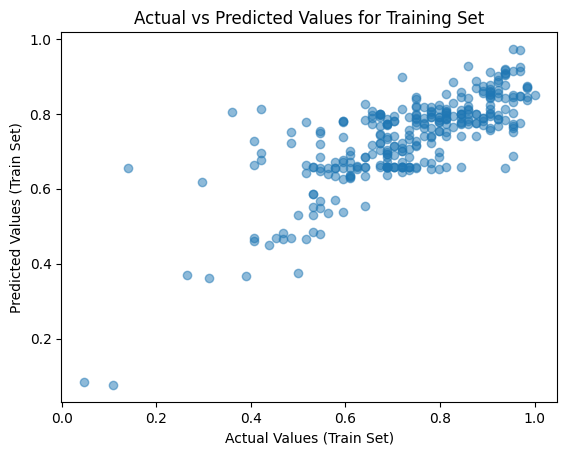

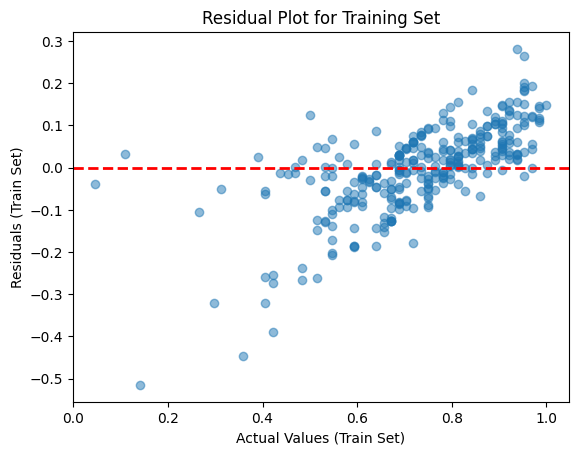

In [13]:
# Generate predictions for the training set
train_predictions = model(x_train)

# Convert torch tensors to NumPy arrays
y_train_np = y_train.numpy()
train_predictions_np = train_predictions.detach().numpy()

# Plot actual vs predicted values for the training set
plt.scatter(y_train_np, train_predictions_np, alpha=0.5)
plt.xlabel('Actual Values (Train Set)')
plt.ylabel('Predicted Values (Train Set)')
plt.title('Actual vs Predicted Values for Training Set')
plt.show()

# Calculate residuals for the training set
train_residuals = y_train_np - train_predictions_np

# Plot residuals for the training set
plt.scatter(y_train_np, train_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)  # Add a horizontal line at y=0 for reference
plt.xlabel('Actual Values (Train Set)')
plt.ylabel('Residuals (Train Set)')
plt.title('Residual Plot for Training Set')
plt.show()


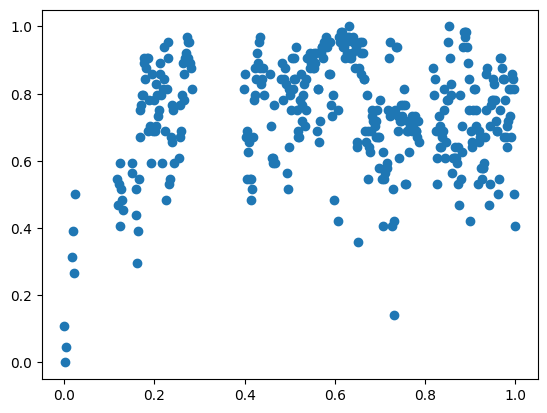

In [14]:
two_composite_1covariates_1hole[['Z','Density_gcm3']]

plt.scatter(two_composite_1covariates_1hole['Z'],two_composite_1covariates_1hole['Density_gcm3'])

In [37]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


test_mse_list = []
test_rmse_list = []
test_mae_list = []
test_r2_list = []


# Assuming your model, data, and metrics functions are defined previously
np.random.seed(42)
torch.manual_seed(42)
# Define the number of folds for cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(x)):
    x_train_fold, x_test_fold = x[train_index], x[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Assuming your model is defined earlier

    # Define your neural network
    model = nn.Sequential(
        nn.Linear(in_features=3, out_features=500),
        nn.ReLU(),
        nn.Linear(in_features=500, out_features=1)
    )

    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []  # To store training losses during training
    test_losses = []   # To store test losses during training

    # Training loop
    for step in range(4000):
        pre = model(x_train_fold)
        mse = mse_loss(pre, y_train_fold.reshape(-1, 1))
        cost = mse

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        pre_test = model(x_test_fold)
        mse_test = mse_loss(pre_test, y_test_fold.reshape(-1, 1))
        test_losses.append(mse_test.item())

    # Store metrics for this fold
    test_predictions_fold = model(x_test_fold).detach().numpy().flatten()
    y_test_fold_flat = y_test_fold.flatten()
    test_mse_list.append(mean_squared_error(y_test_fold_flat, test_predictions_fold))
    test_rmse_list.append(np.sqrt(test_mse_list[-1]))
    test_mae_list.append(mean_absolute_error(y_test_fold_flat, test_predictions_fold))
    test_r2_list.append(r2_score(y_test_fold_flat, test_predictions_fold))

    # Print metrics for the current fold
    print(f"\nMetrics for Fold {fold + 1}:")
    print_metrics(y_test_fold_flat, test_predictions_fold, "Test")

# Print average metrics across folds
print("\nAverage Metrics Across Folds:")
print(f"  Average MSE: {np.mean(test_mse_list):.4f}")
print(f"  Average RMSE: {np.mean(test_rmse_list):.4f}")
print(f"  Average MAE: {np.mean(test_mae_list):.4f}")
print(f"  Average R^2: {np.mean(test_r2_list):.4f}")



Metrics for Fold 1:
Metrics for Test set:
  MSE: 0.0164
  RMSE: 0.1280
  MAE: 0.0931
  R^2: 0.4879


Metrics for Fold 2:
Metrics for Test set:
  MSE: 0.0141
  RMSE: 0.1188
  MAE: 0.0842
  R^2: 0.3979


Metrics for Fold 3:
Metrics for Test set:
  MSE: 0.0166
  RMSE: 0.1289
  MAE: 0.0961
  R^2: 0.4238


Metrics for Fold 4:
Metrics for Test set:
  MSE: 0.0101
  RMSE: 0.1003
  MAE: 0.0745
  R^2: 0.4754


Metrics for Fold 5:
Metrics for Test set:
  MSE: 0.0183
  RMSE: 0.1353
  MAE: 0.0986
  R^2: 0.4318


Average Metrics Across Folds:
  Average MSE: 0.0151
  Average RMSE: 0.1223
  Average MAE: 0.0893
  Average R^2: 0.4434


In [33]:
x_train_fold

tensor([[0.0000, 0.1127, 0.7903],
        [0.0036, 0.1127, 0.7903],
        [0.0178, 0.0282, 0.0161],
        [0.0195, 0.0282, 0.0161],
        [0.0213, 0.0282, 0.0161],
        [0.0231, 0.0282, 0.0161],
        [0.1173, 0.0282, 0.0161],
        [0.1191, 0.0282, 0.0161],
        [0.1208, 0.0282, 0.0161],
        [0.1226, 0.0282, 0.0161],
        [0.1244, 0.0282, 0.0032],
        [0.1262, 0.0282, 0.0000],
        [0.1297, 0.0282, 0.0000],
        [0.1492, 0.0282, 0.0323],
        [0.1510, 0.0282, 0.0323],
        [0.1581, 0.1155, 0.1823],
        [0.1599, 0.2310, 0.3387],
        [0.1617, 0.0423, 0.0839],
        [0.1670, 0.1127, 0.4032],
        [0.1688, 0.1127, 0.4032],
        [0.1706, 0.1127, 0.4032],
        [0.1723, 0.1127, 0.4032],
        [0.1741, 0.1127, 0.4032],
        [0.1759, 0.1127, 0.4032],
        [0.1777, 0.1070, 0.3339],
        [0.1794, 0.0845, 0.0968],
        [0.1812, 0.0845, 0.0968],
        [0.1830, 0.0507, 0.0581],
        [0.1848, 0.0676, 0.1855],
        [0.186